# Wing Watch Sample Tracking

First we will import the Wing Watch package in the normal python fashion. 


In [1]:
import WingWatch as ww

For this guide we will be using a fake calibration data from an included CSV. The calibration data is a gaussian centered at the station expanding out to 500m. This is similar to a omnidirectional antenna. 

I will import the data using pandas read_csv function and save it to a temporary dataframe df. 

In [2]:
import pandas as pd

test_data_file = 'tests/Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)

To visualize the data, I will use matplotlib and generate a scatter plot of the X,Y data colored by RSSI. In practice, the data is three dimensional and the following plot is a 2-D projection of the data. 

Text(0, 0.5, 'y (m)')

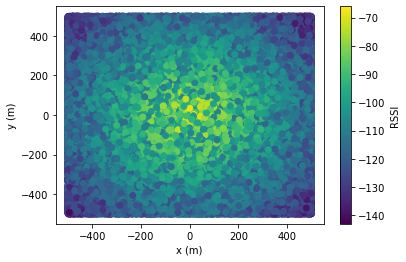

In [3]:
import matplotlib.pyplot as plt

plt.scatter(df.X,df.Y,c=df.RSSI)
plt.colorbar(label='RSSI')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

As is expected, we can see that the strongest signal strength is recieved towards the antenna located at (0,0,0) with the signal decaying at the edges of the field. 

## Adding Stations

Having an arbitrary calibration dataset does not get us very far without utilizing it to locate a putative tag detection. Thus, we will establish three stations to locate the position of a simulated test tag. To do this we will use the Wing Watch Equimpent class to intialize both the station and its associated antenna. To start, I will import their associated functions from the package.

In [4]:
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna

Once the packages are loaded in, we will follow the same process for each station. The steps are as follows:

1) Initalize a station with a name and a position in lat and long
2) Assign an antenna to the station. Include metadata such as antenna number and frequency  
3) Assign our fake calibration data as the antenna's radiation pattern, 
4) Convert the radiation pattern to the local frame of reference. 

Let us start by generating a fake station at (41.1479, -71.5901).

In [5]:
Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)


1 added to Station_1's antennas.


In our validation scheme, I want a system of three stations located in a triangle. The stations will be located at the following locations:

- ($0$,$0$,$0$)
- ($0$,$-200$,$0$)
- ($100 \sqrt{3}$,$-100$,$0$)

Thus, the system would look like this:

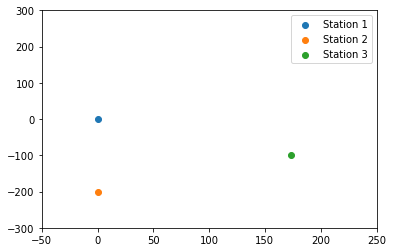

In [6]:
import numpy as np
plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')

plt.xlim([-50,250])
plt.ylim([-300,300])
plt.legend()

To aid in cartesian translations on Earth, Wing Watch comes with a tool which intakes a reference latitude, longitude and altitude and find the new latitude, longitude and altitude given an (X,Y,Z) offset in meters. 

In [7]:
from WingWatch.Tools import translation

Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


Now that we have the locations of the station, we can follow the same steps that we completed for the first station to initalize stations 2 and 3. 

In [8]:
Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


1 added to Station_2's antennas.
1 added to Station_3's antennas.


Once our stations have been initalized, we can begin to locate detections that are recieved by at least three stations. In general, station detections are normally recieved with the following information: 

1) Time Stamp 
2) Station & Antenna Number
3) Recieved signal strength

Let us propose the bird is located at (321,-12,29), the recieved singal strength from station 1, 2 and 3 would be (-94,-99,-81) respectively.Thus we would generate a list of each detection with the following form: 

station_y_single_time_stamp = [[antenna number_0, rssi_0],[antenna number_1, rssi_1,] ....]

For this test data the detection lists would look like:


In [9]:
station_1_data = [[1,-94]]
station_2_data = [[1,-99]]
station_3_data = [[1,-81]]

To the send the data through our triangulation algorithm, we must identify the data and the station which the data came from. This looks like the following:

In [10]:
data_to_send_through = [[station_1_data,Station_1],[station_2_data,Station_2],[station_3_data,Station_3]]

In [11]:
from WingWatch.Intersections import tri

intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)

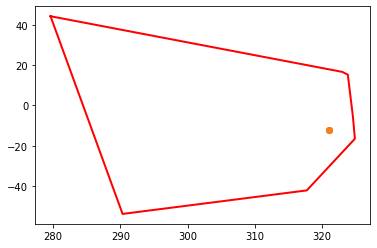

In [12]:
import scipy.spatial as ss

hull_of_intersections = ss.ConvexHull(intersections[:,[0,1]])

points = hull_of_intersections.points
hull_vertices = hull_of_intersections.vertices
hull_vertices = np.append(hull_vertices, hull_vertices[0])
plt.plot(points[hull_vertices, 0], points[hull_vertices, 1], 'r-', lw=2)
plt.scatter(321,-12)
plt.scatter(321,-12)

In [13]:
#Get centoid
cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])

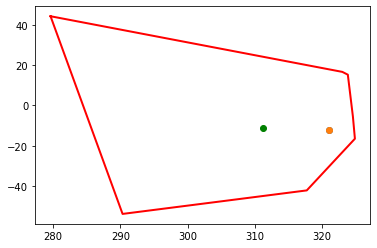

In [14]:
plt.plot(points[hull_vertices, 0], points[hull_vertices, 1], 'r-', lw=2)
plt.scatter(321,-12)
plt.scatter(321,-12)
plt.scatter(cx,cy,c='green')

I generated a random walk of a bird starting at (10, 5, 15) and ending at (301, 7, 16). Let us first plot the walk in relation to all of the stations

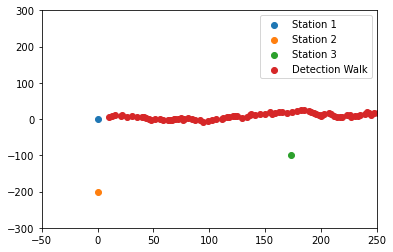

In [15]:
df_walk = pd.read_csv('Random_Walk.csv')

plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')
plt.xlim([-50,250])
plt.ylim([-300,300])
plt.legend()

In [24]:
df_detections = pd.read_csv('Random_Walk_Detections.csv')

points_to_follow = []

#for i in range(len(df_detections['Antenna 1'])):
for i in range(10):
    station_1_data = [[1,df_detections['Antenna 1'][i]]]
    station_2_data = [[1,df_detections['Antenna 2'][i]]]
    station_3_data = [[1,df_detections['Antenna 3'][i]]]
    try:
        data_to_send_through = [[station_1_data,Station_1],[station_2_data,Station_2],[station_3_data,Station_3]]
        intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
        points_to_follow.append([intersections])
    except:
        pass

In [17]:
points_to_follow_flat = np.row_stack(points_to_follow)

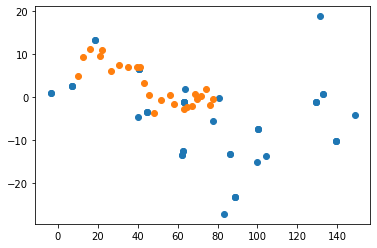

In [18]:
plt.scatter(points_to_follow_flat[:,0],points_to_follow_flat[:,1])
plt.scatter(df_walk.X[0:25],df_walk.Y[0:25])

In [19]:
cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])

In [20]:
import scipy.spatial as ss

hull_of_intersections = ss.ConvexHull(intersections[:,[0,1]])

points = hull_of_intersections.points
hull_vertices = hull_of_intersections.vertices
hull_vertices = np.append(hull_vertices, hull_vertices[0])
plt.plot(points[hull_vertices, 0], points[hull_vertices, 1], 'r-', lw=2)

139.33642760487132

In [21]:
len(points_to_follow_flat)

48

In [22]:
points_to_follow_flat

array([[-3.66273057e+00,  9.43759175e-01],
       [-3.66273057e+00,  9.43759175e-01],
       [ 6.86784693e+00,  2.70153916e+00],
       [ 6.86784693e+00,  2.70153916e+00],
       [ 6.86784693e+00,  2.70153916e+00],
       [ 1.84738086e+01,  1.33630791e+01],
       [ 1.84738086e+01,  1.33630791e+01],
       [ 4.06594069e+01,  6.51096906e+00],
       [ 4.06594069e+01,  6.51096906e+00],
       [ 4.06594069e+01,  6.51096906e+00],
       [ 4.06594069e+01,  6.51096906e+00],
       [ 4.00020168e+01, -4.54284632e+00],
       [ 4.46816058e+01, -3.48931007e+00],
       [ 4.46816058e+01, -3.48931007e+00],
       [ 4.46816058e+01, -3.48931007e+00],
       [ 6.31114447e+01, -1.05059197e+00],
       [ 6.31114447e+01, -1.05059197e+00],
       [ 6.31114447e+01, -1.05059197e+00],
       [ 6.31114447e+01, -1.05059197e+00],
       [ 6.31114447e+01, -1.05059197e+00],
       [ 6.19711148e+01, -1.34692839e+01],
       [ 6.19711148e+01, -1.34692839e+01],
       [ 6.29045315e+01, -1.24453789e+01],
       [ 6.